# LOT STREAMING JOB SHOP SCHEDULING GENETIC ALGORITHM

In this notebook is shown how to use this set of scripts to produce a job shop scheduling with lot streaming with objective makespan. 
**Main features:**
- lot streaming (setting max number of lots for each job)
- Possibility of handling shift constraints
- Possibility of handling sequence dependent setup times

**Scripts**
- params.py | generation of random job shop parameters
- chromosome_generator.py | generation of random chromosomes for GA population
- decoder.py | decodification and evaluation of each chromosome (solution) through active scheduling algorithm (no unnecessary idle times)
- genetic_operators.py | cross-over and mutation operators
- genetic_algorithm.py | genetic algorithm and main script
- plot.py | plotting of Gantt chart with plotly express timeline

**Results were verified to be near to optimal through MILPs models solving small instances.**

In [1]:
# import all the modules (scripts) in the package
import chromosome_generator
import params
import decoder
import genetic_algorithm
from genetic_operators import *

**Libraries used**
- numpy
- random
- pandas
- deap 
- time
- plotly.express

## JOB SHOP PAREMETERS
**Inputs**
- number of machines
- number of jobs
- max number of lots for each job (same for all jobs)
- seed (partial control of random generation)

**Outputs**
- processing times
- setup times
- sequences
  
*Demand is set to 50 units for each job and can be changed after generating the parameters object*

In [2]:
# Parameters
n_machines = 3 # number of machines
n_jobs = 3 # number of jobs
n_lots = 3 # number of lots
seed = 4 # seed for random number generator
demand = {i:50 for i in range(0,n_jobs+1)} # demand of each job

my_params = params.JobShopRandomParams(n_machines=n_machines, n_jobs=n_jobs, n_lots=n_lots, seed=seed)
my_params.demand = demand # demand of each job

When it comes to **print the job shop parameters**, we can choose between **sequence dependent / independent setup times** by setting a boolean argument.

In [3]:
my_params.printParams(sequence_dependent=True)

[MACHINES]: 
 [0 1 2] 

[JOBS]: 
 [0 1 2] 

[BATCHES]: 
 [0 1 2] 

[DEMAND]: 
 {0: 50, 1: 50, 2: 50, 3: 50} 

[PROCESS TIMES]the working time associated with each job on each machine is:
           Job 0  Job 1  Job 2
Machine 0     15      6      2
Machine 1      9      9     19
Machine 2     10      8     14 

[SEQ DEPENDENT SETUP TIMES] row(k) = predecessor | column(j) = successor  
 IMPORTANT! indexes are 1 unit more. 
 IMPORTANT! For job 0, index in sd_setup dictionary is j=1 (successor) or k=1 (predecessor) 
 the setup time associated with each job on each machine is:
Machine  0
        Job 0  Job 1  Job 2
Job -1     50     50     50
Job 0       0     90     59
Job 1      96      0     89
Job 2      55     73      0 

Machine  1
        Job 0  Job 1  Job 2
Job -1     50     50     50
Job 0       0     94     53
Job 1      80      0     50
Job 2      90     88      0 

Machine  2
        Job 0  Job 1  Job 2
Job -1     50     50     50
Job 0       0     88     80
Job 1      71      

## CHROMOSOME GENERATION AND CODIFICATION

Chromosomes consist of 2 parts, the LEFT HAND SIDE (lhs) and the RIGHT HAND SIDE (rhs).

- LHS: for each job there are $u$ real numbers between 0 and 1 that indicate the size of each lot.
- RHS: as this is a JSP, not a FSP, we will have $u$ x $n$ elements in this side, one for each lot of each job.

This codification has been built following the idea showed in this paper.



| 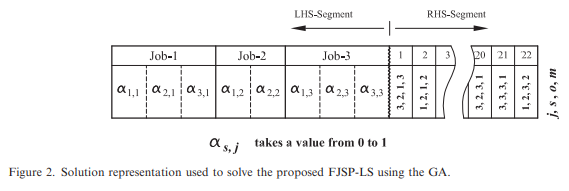| 
|:--:| 
| *Image taken from Fantahun M. Defersha & Mingyuan Chen (2012)* |

Through the script *chromosome_generator.py*, a random chromosome is created. Each one is a list containing both sides. 

### Generation 
- LHS contains a np.array with all $\alpha_ju$ values between 0 and 1 generated with random.random()
- RHS contains a list of tuples. Each tuple refers to each lot of each job.
- CHROMOSOME contains a list with both sides.

 ~~~
chromsome_lhs = np.array([0.24874627, 0.98784599, 0.18476245,..])
chromosome_rhs = [(1, 2), (2, 2), (0, 0),...]
chromosome = [chromosome_lhs, chromosome_rhs]
 ~~~

### Decodification

1. chromosome_lhs values are transformed into integer numbers regarding the demand of each job through the function *decoder.distribute_demand()*<br>
   `chromosome_lhs = np.array([19., 17., 14.,...])`
2. a semi-active schedule (*A feasible schedule is called semiactive if no operation can be completed earlier without
changing the order of processing on any one of the
machines.*) is built through the function *decoder.decode_chromosome* that returns:
- makespan
- y = setup start time of each lot
- c = completion time of each lot
- chromosome_mod = chromosome with LHS containing integer numbers (units of product)
- penalty = shift penalty in case of having lot sizes (traduced in lot processing times) bigger than allowed time windows.

The function *decoder.decode_chromosome* can handle **4 different cases**:
- **no shift** constraints & sequence **independent** setup times
- **shift** constraints & sequence **independent** setup times
- **no shift** constraints & sequence **dependent** setup times
- **shift** constraints & sequence **dependent** setup times

Therefore, later when working with the genetic algorithm we will be able to choose to enable shift constraints and sequence dependent setup times.

*Shift constraints mean all tasks have to be scheduled within a time window, have to start and finish within a time window.*

### Example of generation and decodification


In [4]:
my_chromosome = chromosome_generator.generate_chromosome(my_params)
makespan, penalty, y, c, chromosome_mod  = decoder.decode_chromosome(my_chromosome, my_params, shifts=True, seq_dep_setup=True)
print("Makespan: \n", makespan)
print("Shift penalty: \n", penalty)
print("Setup start times: \n", y)
print("Completion times: \n", c)
print("Chromosome with LHS containing units: \n", chromosome_mod)

Makespan: 
 2118
Shift penalty: 
 0
Setup start times: 
 [[[ 480    0  960]
  [1920 1440 1704]
  [ 840 1225 1585]]

 [[ 960 1440 1226]
  [   0    0    0]
  [   0    0    0]]

 [[1440 1920 1751]
  [ 146    0  410]
  [   0    0    0]]]
Completion times: 
 [[[ 840  230 1225]
  [2118 1585 1807]
  [ 937 1316 1704]]

 [[1226 1548 1352]
  [   0    0    0]
  [   0    0    0]]

 [[1751 2040 1891]
  [ 410  146  450]
  [   0    0    0]]]
Chromosome with LHS containing units: 
 [array([24., 12., 14., 33., 12.,  5., 19., 16., 15.]), [(0, 1), (0, 0), (1, 1), (2, 0), (0, 0), (1, 0), (0, 2), (0, 2), (1, 2), (2, 1), (1, 1), (2, 2), (0, 1), (0, 0), (0, 2), (0, 1), (1, 2), (1, 0)]]


## GENETIC OPERATORS

**crossover** genetic operators are:
- for LHS
  - Single Point Crossover-1 (SPC-1)
  - Single Point Crossover-2 (SPC-2)
- for RHS
  - Partially Mapped Crossover (PMX)
  - Ordered Crossover (OX)
  
**mutation** genetic operators are:
- LHS
  - Sublot Step Mutation (SStM)

 Although more operators can be added, these are sufficient for the GA to function correctly.

## GENETIC ALGORITHM

The GA is developed using the functions from DEAP package. The function is
 
`def run(params, population_size:int, num_generations:int, shifts = False, seq_dep_setup=False, plot=True):`

- Args:
    - params: parameters of the problem
    - population_size: number of individuals in the population
    - num_generations: number of generations
    - shifts: boolean, True if shifts are considered
    - seq_dep_setup: boolean, True if sequence dependent setup times are considered
    - plot: boolean, True if Gantt chart is plotted

- Returns:
    - best_makespan: best fitness value found
    - df_results: parameters of best solution found
  
### Fitness

- NO SHIFT CONSTRAINTS: fitness = makespan
- SHIFT CONSTRAINTS: fitness = makespan + shift penalty

### Selection

In each generation, the initial population is created through **tournament selection**. 
1. 3 individuals are selected from each generated population
2. the best of these 3 (the one with the lowest fitness) is selected to be part of the initial population.
3. Repeat 1 and 2 until having the desired amount of population

### Probabilities for genetic operators

Probabilities may be changed and a DoE could be done to investigate their effects. In this initial performance, selected values are these:

- Crossover operators (SPC1, SPC2, PMX, OX) = 0.8
- Mutation operator (SStM) = 0.2



## PLOTTING

Plotting is made from a dataframe containing the results using the *plotly.express.timeline* function.

When running the GA through *GA.lsjsp_ga*, plotting is done and shown if the arg show is set to True.

```
def gantt(df_results, params, show=True, version=0, shifts=False, seq_dep_setup=False):
    """
    Generates and saves an .html file where is plotted the gantt of a job shop scheduling program

    Args:
        df_results: dataframe with solution parameters
        params: object of class JobShopRandomParams
        demand: dictionary with the demand of each job
        show: wether to open or not the gantt.html file
        version: to keep track of saved files when doing tests
        shifts: to keep track of saved files when doing tests
        seq_dep_setup: to keep track of saved files when doing tests

    Do not return anything.
    """
```

An html file with the gantt chart is generated.

## EXAMPLE OF GA RUN AND SOLUTION PLOT

A piece of code to easily run and plot the solution from the GA.

You can also easily change constraints and parameters

In [5]:
# import libraries
import time 

# --------- PARAMETERS AND CONSTRAINTS (CHANGE FOR DIFFERENT SCENARIOS) ---------
# contraints
shifts_constraint = True
sequence_dependent = True

# Parameters
n_machines = 3  # number of machines
n_jobs = 3  # number of jobs
n_lots = 4  # number of lots
seed = 4  # seed for random number generator
demand = {i: 100 for i in range(0, n_jobs + 1)}  # demand of each job

# Create parameters object
my_params = params.JobShopRandomParams(
    n_machines=n_machines, n_jobs=n_jobs, n_lots=n_lots, seed=seed
)
my_params.demand = demand  # demand of each job
my_params.printParams(sequence_dependent=sequence_dependent, save_to_excel=False)

# --------- GENETIC ALGORITHM (CHANGE FOR DIFFERENT GA CONFIGURATIONS) ---------
# Genetic algorithm
start = time.time()
current_fitness, best_individual = genetic_algorithm.run(
    my_params,
    population_size=100,
    num_generations=50,
    shifts=shifts_constraint,
    seq_dep_setup=sequence_dependent,
    plotting=True,
)
end = time.time()
print("Time elapsed: ", end - start, "seconds")
print("Current fitness: ", current_fitness)
if shifts_constraint:
    makespan, penalty, y, c, chromosome_mod = decoder.decode_chromosome(
        best_individual,
        my_params,
        shifts=shifts_constraint,
        seq_dep_setup=sequence_dependent,
    )
    print("Makespan: ", makespan)
    print("Penalty: ", penalty)
    print("Best chromosome: \n", best_individual)
    print("Best chromosome with LHS decoded: \n", chromosome_mod)

[MACHINES]: 
 [0 1 2] 

[JOBS]: 
 [0 1 2] 

[BATCHES]: 
 [0 1 2 3] 

[DEMAND]: 
 {0: 100, 1: 100, 2: 100, 3: 100} 

[PROCESS TIMES]the working time associated with each job on each machine is:
           Job 0  Job 1  Job 2
Machine 0     15      6      2
Machine 1      9      9     19
Machine 2     10      8     14 

[SEQ DEPENDENT SETUP TIMES] row(k) = predecessor | column(j) = successor  
 IMPORTANT! indexes are 1 unit more. 
 IMPORTANT! For job 0, index in sd_setup dictionary is j=1 (successor) or k=1 (predecessor) 
 the setup time associated with each job on each machine is:
Machine  0
        Job 0  Job 1  Job 2
Job -1     50     50     50
Job 0       0     90     59
Job 1      96      0     89
Job 2      55     73      0 

Machine  1
        Job 0  Job 1  Job 2
Job -1     50     50     50
Job 0       0     94     53
Job 1      80      0     50
Job 2      90     88      0 

Machine  2
        Job 0  Job 1  Job 2
Job -1     50     50     50
Job 0       0     88     80
Job 1      71